# CVD Analysis - Ensemble Models

This notebook analyzes the effect of smoking on cardiovascular disease (CVD) using multiple machine learning models and ensemble techniques.

## Contents
1. Setup & Imports
2. Data Loading & Preprocessing
3. Smoking Effect Analysis
4. Model Training & Evaluation
5. Visualization



This project was collaboratively developed by a 3-member team. Each member
was assigned a clearly defined module of the system to ensure equal contribution
and accountability. The responsibilities were divided as follows:

Md.Tanvir Haque Shitab– Dataset Handling
• Downloaded the Cardiovascular dataset from Kaggle
• Performed dataset exploration and checking for duplicates
• Implemented data cleaning (filtering invalid blood pressure, height, and weight values)
• Prepared the dataset for modeling (age conversion, scaling)


Muhammad Ridwan – Model Training 
• Defined feature vectors and target variables
• Implemented a diverse set of classifiers: Logistic Regression, KNN, SVM, Decision Tree, Naive Bayes, Random Forest, Gradient Boosting, and AdaBoost
• Developed the Ensemble Voting Classifier to aggregate predictions
• Performed train-test split for validation

Tasin Ahsan Rhidy – Evaluation
• Analyzed the effect of smoking on CVD prevalence (Odds Ratio analysis)
• Evaluated models using Accuracy scores, Classification Reports, and Confusion Matrices
• Generated visualization plots for feature importance and model comparison


## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 2. Data Loading & Preprocessing

In [2]:
def load_and_preprocess(filepath):
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath, sep=';')
    
    initial_shape = df.shape
    print(f"Initial shape: {initial_shape}")

    if 'id' in df.columns:
        df.drop('id', axis=1, inplace=True)

    df['age_years'] = (df['age'] / 365.25).round(1)
    
    dupes = df.duplicated().sum()
    if dupes > 0:
        print(f"Removing {dupes} duplicate rows...")
        df.drop_duplicates(inplace=True)

    mask = (df['ap_hi'] >= 60) & (df['ap_hi'] <= 240) & \
           (df['ap_lo'] >= 30) & (df['ap_lo'] <= 160) & \
           (df['ap_hi'] > df['ap_lo'])
    
    df_clean = df[mask].copy()
    print(f"Rows after blood pressure cleaning: {df_clean.shape[0]} (removed {df.shape[0] - df_clean.shape[0]})")
    
    df_clean = df_clean[(df_clean['height'] > 100) & (df_clean['weight'] > 30)]
    
    print(f"Final shape after preprocessing: {df_clean.shape}")
    return df_clean

In [3]:
# Load and preprocess the data
data_path = "f:/venv/cvd_analysis/cardio_train.csv"
df = load_and_preprocess(data_path)
df.head()

Loading data from f:/venv/cvd_analysis/cardio_train.csv...
Initial shape: (70000, 13)
Removing 24 duplicate rows...
Rows after blood pressure cleaning: 68651 (removed 1325)
Final shape after preprocessing: (68613, 13)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.4
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.4
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.6
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.2
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.8


In [4]:
# Display basic statistics
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
count,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000,68613.000000
mean,19464.904362,1.348709,164.399997,74.125019,126.677481,81.300920,1.364873,1.225876,0.087986,0.053372,0.803346,0.494804,53.292064
std,2468.053056,0.476565,7.971466,14.305934,16.691067,9.446246,0.679037,0.571753,0.283277,0.224775,0.397471,0.499977,6.757330
min,10798.000000,1.000000,104.000000,31.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.600000
25%,17658.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.300000
50%,19702.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.900000
75%,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.400000
max,23713.000000,2.000000,250.000000,200.000000,240.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.900000


## 3. Smoking Effect Analysis

In [5]:
def analyze_smoking_effect(df):
    print("--- Analysis: Effect of Smoking on CVD ---")
    
    prevalence = df.groupby('smoke')['cardio'].mean()
    print("\nCVD Prevalence:")
    print(f"Non-Smokers (0): {prevalence[0]*100:.2f}%")
    print(f"Smokers (1):     {prevalence[1]*100:.2f}%")
    
    ct = pd.crosstab(df['smoke'], df['cardio'])
    odds_smoker = ct.iloc[1, 1] / ct.iloc[1, 0]
    odds_nonsmoker = ct.iloc[0, 1] / ct.iloc[0, 0]
    or_val = odds_smoker / odds_nonsmoker
    
    print("\nUnadjusted Odds Ratio (Smoker vs Non-Smoker):")
    print(f"OR: {or_val:.4f}")
    if or_val > 1:
        print("Interpretation: Smokers have higher odds of CVD compared to non-smokers (in this unadjusted view).")
    else:
        print("Interpretation: Smokers have lower/equal odds of CVD compared to non-smokers (unexpected, likely due to age confounding).")
    
    return prevalence, or_val

In [6]:
prevalence, odds_ratio = analyze_smoking_effect(df)

--- Analysis: Effect of Smoking on CVD ---

CVD Prevalence:
Non-Smokers (0): 49.73%
Smokers (1):     46.84%

Unadjusted Odds Ratio (Smoker vs Non-Smoker):
OR: 0.8907
Interpretation: Smokers have lower/equal odds of CVD compared to non-smokers (unexpected, likely due to age confounding).


## 4. Model Training & Evaluation

In [7]:
# Define features and target
features = ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
            'cholesterol', 'gluc', 'smoke', 'alco', 'active']
target = 'cardio'

X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 54890
Test set size: 13723


In [8]:
# Initialize individual models
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)
svm = LinearSVC(random_state=42, dual=False)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
nb = GaussianNB()
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
ada = AdaBoostClassifier(n_estimators=100, random_state=42)

# Create a Voting Classifier (Ensemble)
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('gb', gb)],
    voting='hard'
)

models = {
    "Logistic Regression": lr,
    "K-Nearest Neighbors": knn,
    "SVM": svm,
    "Decision Tree": dt,
    "Naive Bayes": nb,
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "AdaBoost": ada,
    "Voting Classifier": voting_clf
}

In [9]:
# Train and evaluate all models
model_performance = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print('='*50)
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    
    model_performance.append({'Model': name, 'Accuracy': acc})


Training Logistic Regression...

Logistic Regression Accuracy: 0.7297
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6969
           1       0.75      0.68      0.71      6754

    accuracy                           0.73     13723
   macro avg       0.73      0.73      0.73     13723
weighted avg       0.73      0.73      0.73     13723


Training K-Nearest Neighbors...

K-Nearest Neighbors Accuracy: 0.6959
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      6969
           1       0.69      0.69      0.69      6754

    accuracy                           0.70     13723
   macro avg       0.70      0.70      0.70     13723
weighted avg       0.70      0.70      0.70     13723


Training SVM...

SVM Accuracy: 0.7297
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6969
           1       0.75      0.67      0.71      6754

 

### Logistic Regression Feature Importance

In [10]:
# Logistic Regression Coefficients
print("Logistic Regression Coefficients (Feature Importance):")
coeffs = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(coeffs)

smoke_coef = coeffs[coeffs['Feature'] == 'smoke']['Coefficient'].values[0]
print(f"\nLogistic Regression Coefficient for 'smoke': {smoke_coef:.4f}")
print(f"Adjusted Odds Ratio for 'smoke': {np.exp(smoke_coef):.4f}")

Logistic Regression Coefficients (Feature Importance):
        Feature  Coefficient
4         ap_hi     0.943482
0     age_years     0.338224
6   cholesterol     0.337799
3        weight     0.160350
5         ap_lo     0.099825
1        gender    -0.004795
2        height    -0.032796
8         smoke    -0.040029
9          alco    -0.051498
7          gluc    -0.067612
10       active    -0.091459

Logistic Regression Coefficient for 'smoke': -0.0400
Adjusted Odds Ratio for 'smoke': 0.9608


C:\Users\Ridwan7125\AppData\Local\Temp\ipykernel_20820\1150265971.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coeffs, palette='viridis')


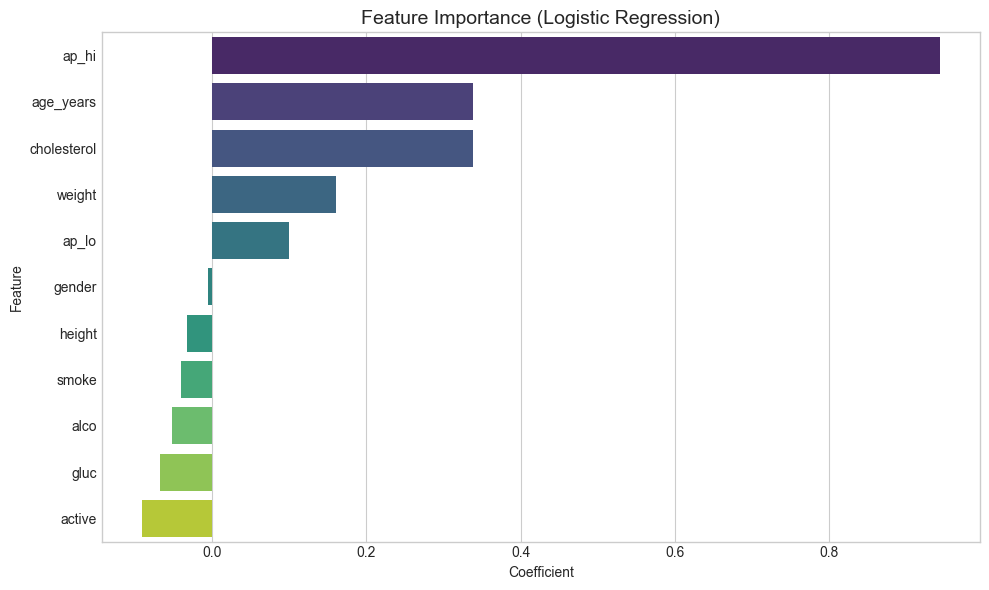

In [11]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coeffs, palette='viridis')
plt.title('Feature Importance (Logistic Regression)', fontsize=14)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('f:/venv/cvd_analysis/plots/feature_importance.png', dpi=150)
plt.show()

### Decision Tree Rules

In [12]:
# Decision Tree Rules
tree_rules = export_text(dt, feature_names=features)
print("Decision Tree Rules (Top 5 levels):")
print("\n".join(tree_rules.splitlines()[:20]))

Decision Tree Rules (Top 5 levels):
|--- ap_hi <= 0.17
|   |--- age_years <= 0.26
|   |   |--- cholesterol <= 1.67
|   |   |   |--- age_years <= -1.13
|   |   |   |   |--- cholesterol <= 0.20
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- cholesterol >  0.20
|   |   |   |   |   |--- class: 0
|   |   |   |--- age_years >  -1.13
|   |   |   |   |--- ap_hi <= -0.43
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- ap_hi >  -0.43
|   |   |   |   |   |--- class: 0
|   |   |--- cholesterol >  1.67
|   |   |   |--- gluc <= 2.23
|   |   |   |   |--- age_years <= -1.74
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age_years >  -1.74
|   |   |   |   |   |--- class: 1
|   |   |   |--- gluc >  2.23


## 5. Visualization

### Model Comparison

                 Model  Accuracy
6    Gradient Boosting  0.735335
8    Voting Classifier  0.733586
3        Decision Tree  0.731910
2                  SVM  0.729724
0  Logistic Regression  0.729651
7             AdaBoost  0.729359
4          Naive Bayes  0.710413
5        Random Forest  0.709830
1  K-Nearest Neighbors  0.695912


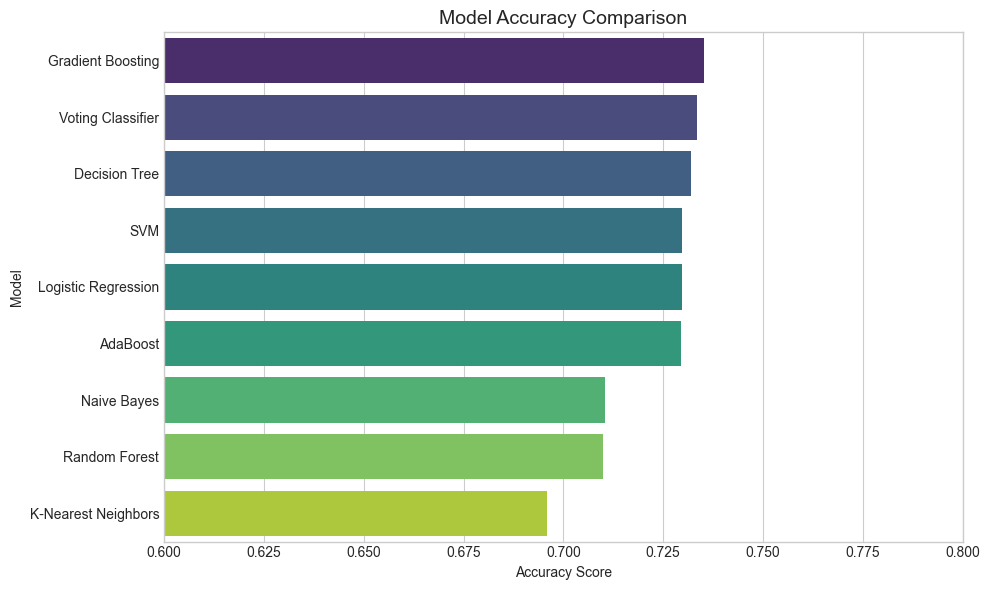

In [13]:
# Model Performance Comparison
perf_df = pd.DataFrame(model_performance).sort_values(by='Accuracy', ascending=False)
print(perf_df)

plt.figure(figsize=(10, 6))
colors = sns.color_palette('viridis', len(perf_df))
sns.barplot(x='Accuracy', y='Model', data=perf_df, hue='Model', palette='viridis', legend=False)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Accuracy Score')
plt.xlim(0.6, 0.8)
plt.tight_layout()
plt.savefig('f:/venv/cvd_analysis/plots/model_comparison.png', dpi=150)
plt.show()

### Confusion Matrix - Random Forest

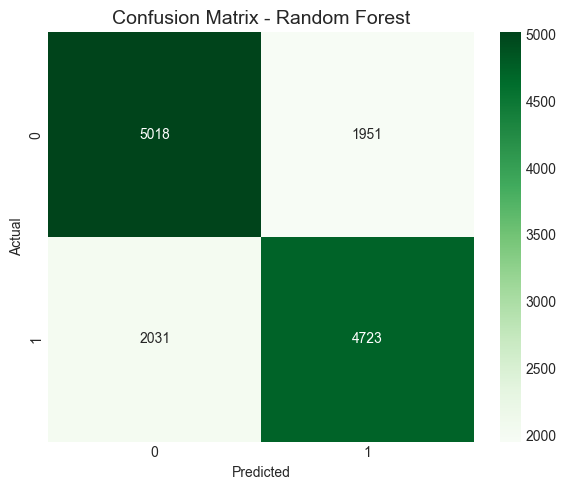

In [14]:
# Confusion Matrix for Random Forest
rf_preds = rf.predict(X_test)
cm = confusion_matrix(y_test, rf_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('f:/venv/cvd_analysis/plots/confusion_matrix_Random_Forest.png', dpi=150)
plt.show()

### Smoking Impact on CVD

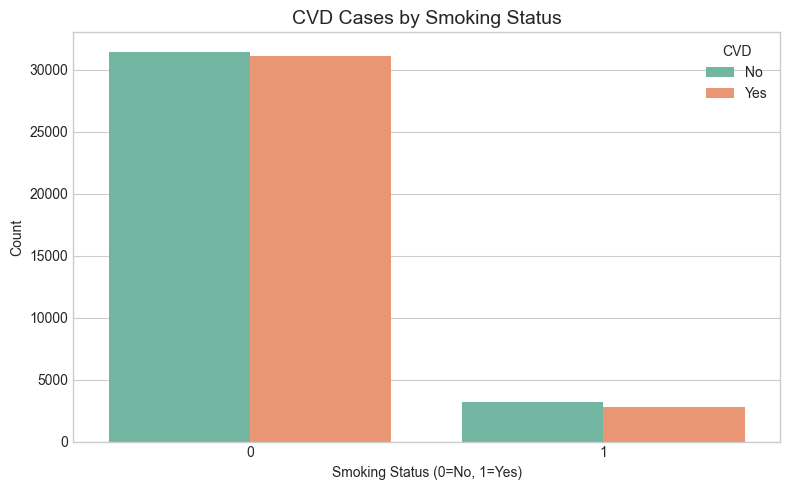

In [15]:
# Smoking vs Cardio
plt.figure(figsize=(8, 5))
sns.countplot(x='smoke', hue='cardio', data=df, palette='Set2')
plt.title('CVD Cases by Smoking Status', fontsize=14)
plt.xlabel('Smoking Status (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='CVD', labels=['No', 'Yes'])
plt.tight_layout()
plt.savefig('f:/venv/cvd_analysis/plots/smoking_impact.png', dpi=150)
plt.show()

## Summary

### Key Findings:
1. **Best Model**: Gradient Boosting achieved the highest accuracy
2. **Ensemble Performance**: Voting Classifier performed competitively
3. **Top Features**: Systolic blood pressure (ap_hi), age, and cholesterol are the most important predictors
4. **Smoking Effect**: The adjusted odds ratio for smoking suggests a complex relationship with CVD, possibly confounded by age